This notebook is a supplement to the paper "Compatibility and accessibility: lattice representations for semantics of non-classical and modal logic" (https://arxiv.org/abs/2201.07098) by Wesley H. Holliday (wesholliday@berkeley.edu).

To view the notebook online, type the URL of this notebook (https://github.com/wesholliday/compat-frames/blob/main/compat-frames.ipynb) into the location field at https://nbviewer.org. GitHub's preview of the notebook does not show all the output that was generated.


# Notebook Outline

## I. [Supplement to Section 2](#I)

**I.I [Drawing compatibility frames](#I.I)**

**I.II [Calculating fixpoints of the closure operator](#I.II)**

**I.III [Hasse diagrams of the fixpoint lattices](#I.III)**

**I.IV [Generating compatibility frames up to isomorphism](#I.IV)**

**I.V [Generating fixpoint lattices up to isomorphism](#I.V)**

This section already verifies the part of Conjecture 3.13 in the paper for lattices of size $\leq 8$.

**I.VI [The $\neg_\vartriangleleft$ operation](#I.V)**


## II. [Supplement to Section 3.1](#II)

**II.I [The compatibility relation of Def. 3.5(i)](#II.1)**

**II.II [Finding join-irreducibles in the fixpoint lattice](#II.II)**

**II.III [Generating anti-inflationary functions](#II.III)**

**II.IV [Checking whether lattices can be represented as in Def. 3.5(i)](#II.IV)**

**II.V [Checking whether a lattice can be represented as in Def. 3.5(i) for a given $\neg$ and/or $\mathrm{V}$](#II.V)**

**II.VI [All lattices of size $\leq 8$ can be represented as in Def. 3.5(i)](#II.VI)**

**II.VII [Verification of Conjecture 3.13 for lattices of size $\leq 16$](#II.VII)**


## III. [Supplement to Appendix A.1](#III)

**III.I [Generating protocomplementations](#III.I)**

**III.II [Lattices for which no protocomplementation makes the representation of Def. 3.5(i) apply](#III.II)**

**III.III [Checking whether $(𝐿,¬)$ can arise from a compatibiltiy frame](#III.III)**

### Preliminaries

In [830]:
from itertools import chain, combinations, product
import copy
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import pickle
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from pprint import pprint
from tqdm.notebook import tqdm
from functools import partial

In [831]:
def powerset(iterable):
    """powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# I. Supplement to Section 2 <a id='I'></a>

## I.I Drawing compatibility frames <a id='I.I'></a>

According to Convention 2.2 in the paper, to represent the compatibility frame $(X,\vartriangleleft)$, we draw an arrow from $y$ to $x$ when $x\vartriangleleft y$. Thus, we draw the directed graph $(X,\vartriangleright)$ to represent the compatibility frame $(X,\vartriangleleft)$. Reflexive loops are not drawn.

In [832]:
def domain(rel):
    """given a reflexive relation, returns the domain of the relation"""
    X = {pair[0] for pair in rel}
    
    return X

In [833]:
def draw_flipped_digraph(rel,X = None):
    """given a relation rel on X, draw the digraph (with no loops) for the inverse of rel;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""
    
    if X is None:
        X = domain(rel)
    
    g = nx.DiGraph()
    g.add_nodes_from(X)
    
    for pair in rel:
        if not pair[0] == pair[1]:
            g.add_edge(pair[1],pair[0])
    
    nx.draw(g, with_labels=True, arrowsize=15)
    plt.show() 

## I.II Calculating fixpoints of the closure operator <a id='I.II'></a>

In [834]:
def closure(A,rel,X = None):
    """given a subset A of X, returns the closure of A according to the closure operator
    c_rel defined in Def. 2.4 of the paper from the given relation rel on X;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""

    if X is None:
        X = domain(rel)
    
    Aset = set(A)
    Xset = set(X)
    closure = [x for x in A]
   
    for x in Xset - Aset:
        x_sees = {y for y in X if (y,x) in rel}
        seen_by_A = {z for z in X if any([pair[0]==z and pair[1] in Aset for pair in rel])}
        if x_sees.issubset(seen_by_A):
            closure.append(x)
        
    return closure

For small compatibility frames, we can simply check for each subset whether it is a fixpoint of the closure operator.

In [835]:
def fixpoints(rel,X = None):
    """given a binary relation rel on X, returns the fixpoints of c_rel according to Def. 2.4 in the paper"""

    if X is None:
        X = domain(rel)
    
    fixpts = [(), tuple(X)]
    
    pwrset = powerset(X)

    for A in pwrset:
        if A == () or A == tuple(X):
            continue
            
        if A == tuple(closure(A,rel,X)):
            fixpts.append(A)

    return fixpts

To handle larger compatibility frames, we can use Ganter's algorithm to calculate fixpoints of a closure operator (Ganter B. (2010), "Two Basic Algorithms in Concept Analysis." In: Kwuida L., Sertkaya B. (eds) Formal Concept Analysis. ICFCA 2010. *Lecture Notes in Computer Science*, vol 5986. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-11928-6_22). 

Ganter's algorithm assumes a closure operator on the powerset of a set $X$ where $X$ is an initial segment of the natural numbers (or otherwise linearly ordered). Thus, we include a function to convert a given compatibility frame to an isomorphic copy whose domain is an initial segment of the natural numbers.

In [836]:
def convert_to_nums(rel, X = None):
    """Given a compatibility frame, return an isomorphic copy
    whose domain is an initial segment of the natural numbers plus
    a dictionary to go back from natural numbers to the original elements"""
    
    if X is None:
        X = domain(rel)
    
    forward_map = {}
    inverse_map = {}
    count = 0
    
    for x in X:
        forward_map[x] = count
        inverse_map[count] = x
        count += 1   
    
    newrel = []
    
    for pair in rel:
        newrel.append((forward_map[pair[0]],forward_map[pair[1]]))
    
    return newrel, inverse_map

We implement the algorithm on p. 316 of Ganter's paper with the following two functions.

In [837]:
def next_fixpoint(A, rel, X = None):
    """Given a compatibility frame rel on an initial segment of the natural numbers
    and a subset A, assumed to be a fixpoint, calculate the next fixpoint
    according to Ganter's lectic ordering"""
    
    if X is None:
        X = domain(rel)
        
    Aset = set(A)
    
    for i in reversed(X):
        if not i in Aset:
            iset = set(range(i))
            inter = Aset.intersection(iset)
            union = inter.union({i})
            Anext = closure(union, rel, X)
            if [j for j in Anext if j<i and not j in Aset] == []:
                return tuple(Anext)  

In [838]:
def Ganter_fixpoints(rel, X = None):
    """Given a compatibility frame rel, return the fixpoints according to Ganter's algorithm;
    if rel is not already on an initial segment of the natural numbers, 
    apply convert_to_nums in order to run next_fixpoint and then apply 
    the inverse map to get corresponding fixpoints for the original rel"""
    
    if X is None:
        X = domain(rel)
        
    if tuple(X) == tuple(range(len(X))):
        
        setX = set(X)
        listX = list(X)
    
        fixpts = [()]
        A = ()
    
        while not set(A) == setX:
            A_next = next_fixpoint(A,rel,listX)
            A = A_next
            fixpts.append(A_next)
        
        return fixpts
    
    else:
        conv = convert_to_nums(rel, X)
        newrel = conv[0]
        inverse = conv[1]
        newX = domain(newrel)
        
        setX = set(newX)
        listX = list(newX)
        
        fixpts = [()]
        A = ()
    
        while not set(A) == setX:
            A_next = next_fixpoint(A,newrel,listX)
            A = A_next
            A_next_inverse = tuple({inverse[a] for a in A_next})
            fixpts.append(A_next_inverse)
        
        return fixpts

### Examples

In [839]:
# when defining compatibility frames, 
# in order to avoid entering pairs (x,x) manually, we use the following:

def reflexive_closure(rel,X):
    """given a binary relation rel on X, returns the reflexive closure of rel"""
    relset = set(rel)

    for x in X:
        if not (x,x) in relset:
            rel.append((x,x))
    return rel

Fig. 1, left:


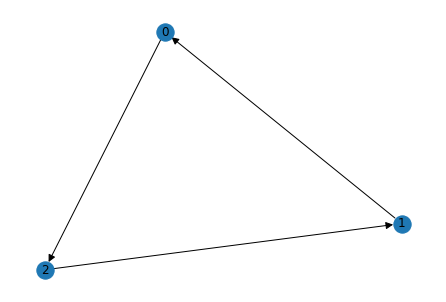

compatibility frame: [(0, 1), (1, 2), (2, 0), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0, 1, 2), (0,), (1,), (2,)]


Fig. 1, right:


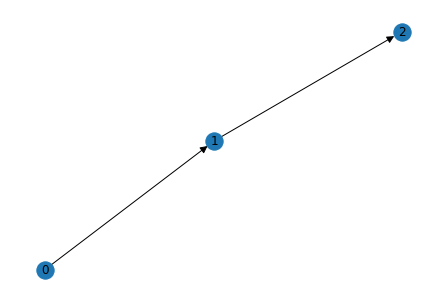

compatibility frame: [(1, 0), (2, 1), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0, 1, 2), (0,), (2,), (1, 2)]


Fig. 2:


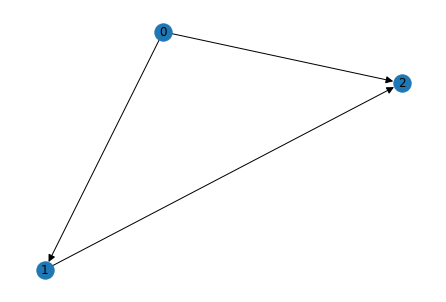

compatibility frame: [(1, 0), (2, 1), (2, 0), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0, 1, 2), (2,), (1, 2)]


Fig. 3, left:


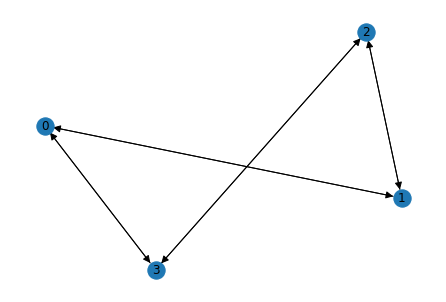

compatibility frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 0), (0, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (2,), (3,)]


Fig. 3, right:


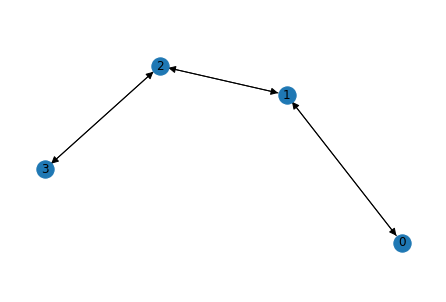

compatibility frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (3,), (0, 1), (2, 3)]


Fig. 6:


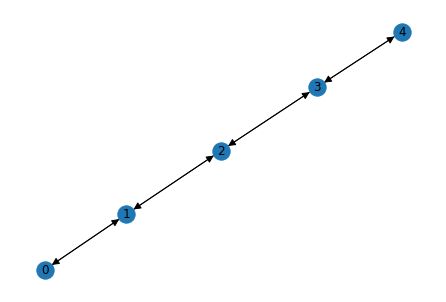

compatibility frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
fixpoints: [(), (0, 1, 2, 3, 4), (0,), (2,), (4,), (0, 1), (0, 4), (3, 4), (0, 1, 2), (2, 3, 4)]


Fig. A.1:


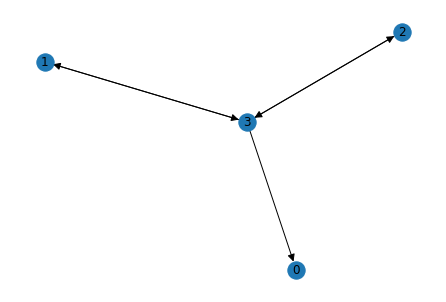

compatibility frame: [(0, 3), (1, 3), (3, 1), (2, 3), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2)]


Another example not in the paper:


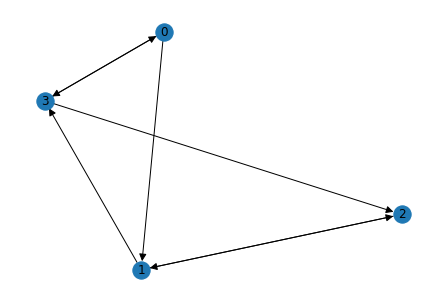

compatibility frame: [(1, 0), (1, 2), (2, 1), (0, 3), (3, 0), (3, 1), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (2,), (3,), (1, 2)]




In [840]:
# below we reproduce all examples from figures in the paper:

exs = {0: ("Fig. 1, left:",reflexive_closure([(0,1),(1,2),(2,0)],range(3))), 
       1: ("Fig. 1, right:",reflexive_closure([(1,0),(2,1)],range(3))),
       2: ("Fig. 2:",reflexive_closure([(1,0),(2,1),(2,0)],range(3))),
       3: ("Fig. 3, left:",reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2),(3,0),(0,3)],range(4))),
       4: ("Fig. 3, right:",reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2)],range(4))),
       5: ("Fig. 6:",reflexive_closure([(0,1),(1,0), (1,2), (2,1), (2,3), (3,2),(3,4),(4,3)],range(5))),
       6: ("Fig. A.1:",reflexive_closure([(0,3), (1,3), (3,1), (2,3), (3,2)],range(4))),
       7: ("Another example not in the paper:",reflexive_closure([(1,0),(1,2),(2,1),(0,3),(3,0),(3,1),(2,3)],range(4)))
      }
   
for i in range(8):
    print(exs.get(i)[0])
    draw_flipped_digraph(exs.get(i)[1])
    print(f"compatibility frame: {exs.get(i)[1]}")
    print(f"fixpoints: {fixpoints(exs.get(i)[1])}")
    print("\n")
    
# saving the last example for later:

example_rel = reflexive_closure([(1,0),(1,2),(2,1),(0,3),(3,0),(3,1),(2,3)],range(4))
example_fixpts = fixpoints(example_rel)

## I.III Hasse diagrams of the fixpoint lattices <a id='I.III'></a>

Given a family of fixpoints, we first calculate the proper subset relation between fixpoints, then calculate the associated covering relation, and finally create a networkx digraph for the Hasse diagram of the fixpoint lattice.

In [841]:
def propsubrel(lt):
    """given a list of tuples representing a set of sets, returns the proper subset relation as a list of pairs"""
    propsubrel = []
    
    for A in lt:
        for B in lt:  
            if set(A).issubset(set(B)) and not set(B).issubset(set(A)):
                propsubrel.append((A,B))
                
    return propsubrel

In [842]:
print(propsubrel(example_fixpts))

[((), (0, 1, 2, 3)), ((), (0,)), ((), (2,)), ((), (3,)), ((), (1, 2)), ((0,), (0, 1, 2, 3)), ((2,), (0, 1, 2, 3)), ((2,), (1, 2)), ((3,), (0, 1, 2, 3)), ((1, 2), (0, 1, 2, 3))]


In [843]:
def covering(spo):
    """given a strict partial order spo, returns the associated covering relation"""
    cover = copy.deepcopy(spo)
    for p1 in spo:
        for p2 in spo:
            if p1 in cover and p1[0] == p2[0] and (p2[1],p1[1]) in spo:
                cover.remove(p1)
                break
    return cover

In [844]:
print(covering(propsubrel(example_fixpts)))

[((), (0,)), ((), (2,)), ((), (3,)), ((0,), (0, 1, 2, 3)), ((2,), (1, 2)), ((3,), (0, 1, 2, 3)), ((1, 2), (0, 1, 2, 3))]


In [845]:
def lattice(rel,X = None):
    """given a relation rel on X, returns the Hasse diagram of the lattice of fixpoints"""
    
    if X is None:
        X = set([pair[0] for pair in rel]) 
        
    fix = fixpoints(rel,X)
    cover = covering(propsubrel(fix))
    l = nx.DiGraph()
    l.add_nodes_from(fix)
    l.add_edges_from(cover) 
    
    return l

Since we use graphviz dot to display the lattices, and graphviz dot draws arrows going down, an arrow from $y$ down to $x$ means that $x\leq y$ in our lattice.

In [846]:
def display_lattice(l):
    
    lrev = nx.DiGraph.reverse(l) 
    # We reverse the lattice arrows because graphviz draws all arrows going down, 
    # so if we did not do this, the top element of the lattice would appear at the bottom
    
    pos = graphviz_layout(lrev, prog="dot")
    nx.draw(lrev, pos, with_labels=True, arrowsize=15)
    plt.show() 

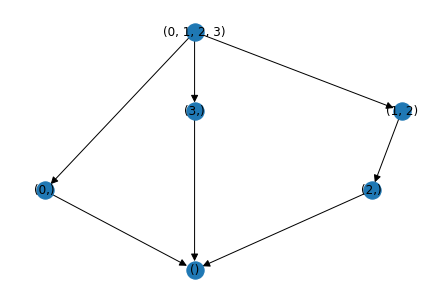

In [847]:
l = lattice(example_rel)

display_lattice(l)

## I.IV Generating compatibility frames up to isomorphism  <a id='I.IV'></a>

In this section, we generate all compatibility frames of size $n$ up to isomorphism by generating all directed graphs (without loops) of size $n$ up to isomorphism and then adding all reflexive loops.

To obtain all directed graphs of size $n$ up to isomorphism, we use nauty:

http://users.cecs.anu.edu.au/~bdm/nauty/

B. D. McKay and A. Piperno, Practical Graph Isomorphism, II, J. Symbolic Computation (2013) 60 94-112. https://doi.org/10.1016/j.jsc.2013.09.003. Preprint version at https://arxiv.org/abs/1301.1493.

After installing nauty, the command line command

geng n | directg -T > digraphs_n.txt

outputs all directed graphs of size $n$ up to isomorphism in digraphs_n.txt. I stored digraphs_1.txt through digraphs_5.txt in the digraphs directory in GitHub. The file digraphs_6.txt was too large (at 100 MB), but it can be generated locally as above.

Each line of digraphs_n.txt has the following format:

num_vertices num_edges edges.

The integer sequence for the number of nonempty directed graphs up to isomorphism with $n$ nodes (https://oeis.org/A000273) begins as follows: $1, 3, 16, 218, 9608, 1540944, 882033440, \dots$

In [848]:
def readgraphs(filename):
    """converts each line from the nauty output file into a list of pairs representing edges"""
    file = open(filename)
    lines = file.readlines()
    graphs = []

    for line in lines:
        edges = []
        l = line.split(" ")
        num_vertices = int(l[0])
        num_edges = int(l[1])
        for i in range(num_edges):
            edges.append( (int(l[2*i+2]), int(l[2*i+3]) ))
        graphs.append(edges)

    return graphs

In [849]:
def make_reflexive(rels,X):
    """given a list of relations, returns the reflexive closures of each"""
    newrels = []
    for rel in rels:
        newrel = reflexive_closure(rel,X)
        newrels.append(newrel)
    return newrels

In [850]:
def comp_frames_size(n):
    """returns a representative of each isomorphism class of compatibiliy frames of size n"""
    dgs = readgraphs(f"digraphs/digraphs{n}.txt")
    rdgs = make_reflexive(dgs,range(n))
    
    return rdgs

In [851]:
print(len(comp_frames_size(5)))

9608


## I.V Generating fixpoint lattices up to isomorphism  <a id='I.V'></a>

Using a naive approach, we can fairly quickly generate all fixpoints lattices up to isomorphism arising from directed graphs of size $\leq 5$ up to isomorphism. Doing so for directed graphs of size $6$ takes much longer.

The integer sequence for the number of nondegenerate lattices up to isomorphism with n nodes (https://oeis.org/A006966) begins as follows: $1, 1, 1, 2, 15, 53, 222, 1078, 5994 \dots$

In [852]:
num_lats_of_size = {2: 1, 3: 1, 4: 1, 5: 2, 6: 15, 7: 53, 8: 222}

In [853]:
def all_lattices(rels):
    """given a collection rels of relations, returns all the fixpoint lattices"""
    
    lattices = []
    
    for rel in tqdm(rels):
        l = lattice(rel)
        lattices.append(l)
       
    return lattices

In [854]:
def lattices(rels):
    """given a collection rels of relations, returns all the fixpoint lattices up to isomorphism"""

    lattices = []

    for rel in tqdm(rels):
        l = lattice(rel)
        newlat = True
        for l2 in lattices:
            if nx.is_isomorphic(l,l2):
                newlat = False
                break
        if newlat:
            lattices.append(l)
       
    return lattices

In [855]:
def lattices_size(rels, n):
    """given a collection rels of relations, returns all the fixpoint lattices of size n up to isomorphism"""

    lattices = []

    for rel in tqdm(rels):
        if len(fixpoints(rel)) == n:
            l = lattice(rel)
            newlat = True
            for l2 in lattices:
                if nx.is_isomorphic(l,l2):
                    newlat = False
                    break
            if newlat:
                lattices.append(l)
      
    return lattices

In [856]:
def lattices_keep_rels(rels):
    """given a collection rels of relations, returns all the fixpoint lattices up to isomorphism,
    plus the relation from which each came"""

    rel_lat = []

    for rel in tqdm(rels):
        l = lattice(rel)
        newlat = True
        for pair in rel_lat:
            l2 = pair[1]
            if nx.is_isomorphic(l,l2):
                newlat = False
                break
        if newlat:
            rel_lat.append((rel,l))
       
    return rel_lat

In [857]:
def num_each_size(lats):
    """returns the number of lattices in lats of each size"""
    d = {}
    
    for l in lats:
        num = len(l.nodes)
        if num in d.keys():
            d[num] = d[num]+1
        if not num in d.keys():
            d[num] = 1
            
    return d

### Lattices from compatibility frames of size 1-4

In [858]:
lattices_keep_rels_from_comp_frames_size = {n: lattices_keep_rels(comp_frames_size(n)) for n in range(1,5)}

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

In [859]:
lattices_from_comp_frames_size = {n: lattices(comp_frames_size(n)) for n in range(1,5)}

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

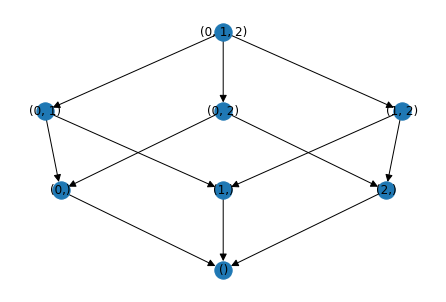

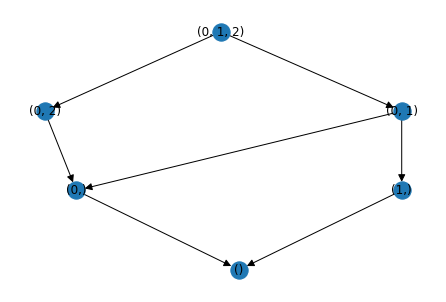

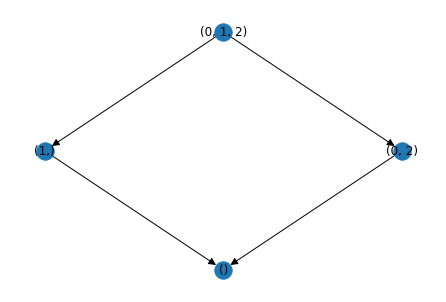

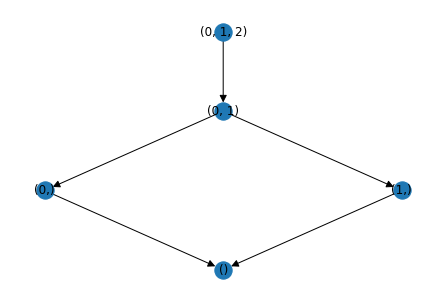

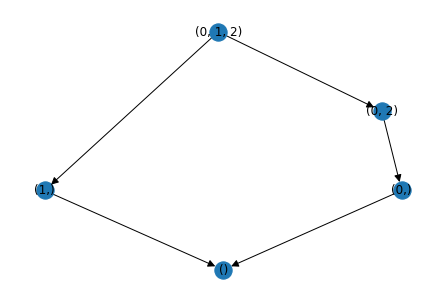

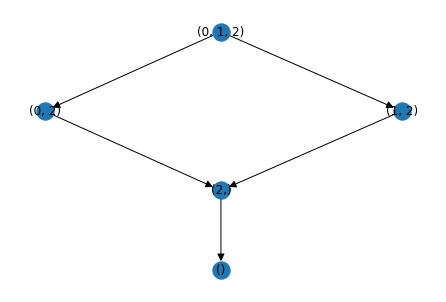

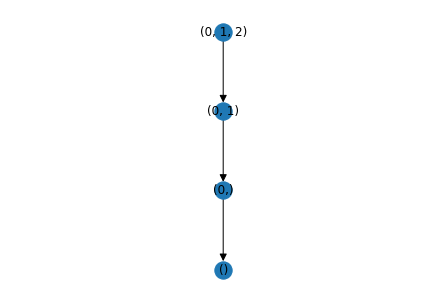

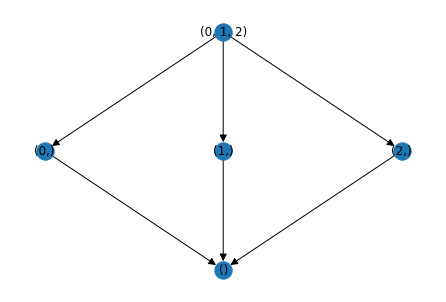

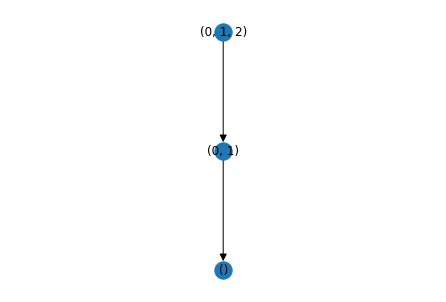

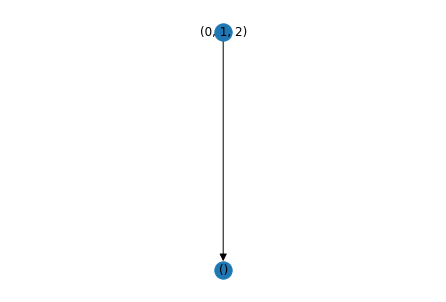

In [860]:
for l in lattices_from_comp_frames_size[3]:
        display_lattice(l)
        print("\n")

In [861]:
for n in range(1,5):
    print(f"Number of compatibility frames of size {n} up to iso: {len(comp_frames_size(n))}")
    print(f"Number of lattices up to iso from compatibility frames of size {n}: {len(lattices_from_comp_frames_size[n])}")
    print("\n")

Number of compatibility frames of size 1 up to iso: 1
Number of lattices up to iso from compatibility frames of size 1: 1


Number of compatibility frames of size 2 up to iso: 3
Number of lattices up to iso from compatibility frames of size 2: 3


Number of compatibility frames of size 3 up to iso: 16
Number of lattices up to iso from compatibility frames of size 3: 10


Number of compatibility frames of size 4 up to iso: 218
Number of lattices up to iso from compatibility frames of size 4: 59




In [862]:
for n in range(1,5):
    d = num_each_size(lattices_from_comp_frames_size[n])
    print(f"Number of lattices of each size arising from compatibility frames of size {n}:")
    pprint(d)
    print("\n")

Number of lattices of each size arising from compatibility frames of size 1:
{2: 1}


Number of lattices of each size arising from compatibility frames of size 2:
{2: 1, 3: 1, 4: 1}


Number of lattices of each size arising from compatibility frames of size 3:
{2: 1, 3: 1, 4: 2, 5: 4, 6: 1, 8: 1}


Number of lattices of each size arising from compatibility frames of size 4:
{2: 1, 3: 1, 4: 2, 5: 5, 6: 14, 7: 14, 8: 6, 9: 9, 10: 5, 12: 1, 16: 1}




The computation above shows (recall https://oeis.org/A006966) that all lattices of size $\leq 5$ can be represented as lattices of fixpoints arising from compatibility frames of size $4$. Moreover, $14$ of the $15$  lattices of size $6$ up to isomorphism can be so represented. The missing one is the $6$-element chain arising as the fixpoint lattice of the $5$-element linear order, as we verify below.

In [863]:
def linear_order(n):
    """returns the n-element linear order as a list of pairs"""
    l = []

    for i in range(n):
        for j in range (n):
            if i<=j:
                l.append((i,j))
            
    return l

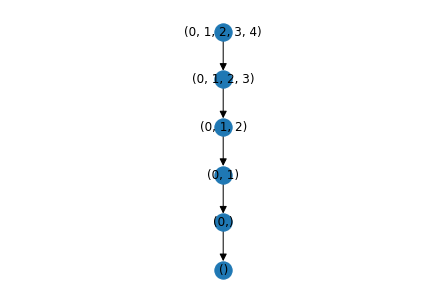

In [864]:
l = lattice(linear_order(5))

display_lattice(l)

In [865]:
def iso_copy_in(lat,lats):
    """checks whether lats contains an isomorphic copy of lat"""
    iso = False
    for l in lats:
        if l.nodes == lat.nodes:
            if nx.is_isomorphic(lat,l):
                iso = True
                break
    return iso

In [866]:
iso_copy_in(lattice(linear_order(5)),lattices_from_comp_frames_size[4])

False

### Lattices from compatibility frames of size 5

We separate the generation of lattices up to isomorphism from compatibility frames of size 5, since this takes a bit longer.

In [867]:
lattices_keep_rels_from_comp_frames_size[5] = lattices_keep_rels(comp_frames_size(5))

  0%|          | 0/9608 [00:00<?, ?it/s]

In [868]:
lattices_from_comp_frames_size[5] = [pair[1] for pair in lattices_keep_rels_from_comp_frames_size[5]]

In [869]:
n=5

print(f"Number of compatibility frames of size {n} up to iso: {len(comp_frames_size(n))}")
print(f"Number of lattices up to iso from compatibility frames of size {n}: {len(lattices_from_comp_frames_size[n])}")

Number of compatibility frames of size 5 up to iso: 9608
Number of lattices up to iso from compatibility frames of size 5: 876


In [870]:
n=5

d = num_each_size(lattices_from_comp_frames_size[n])
print(f"Number of lattices of each size arising from compatibility frames of size {n}:")
pprint(d)

Number of lattices of each size arising from compatibility frames of size 5:
{2: 1,
 3: 1,
 4: 2,
 5: 5,
 6: 15,
 7: 52,
 8: 112,
 9: 130,
 10: 151,
 11: 159,
 12: 91,
 13: 60,
 14: 41,
 15: 15,
 16: 9,
 17: 16,
 18: 9,
 20: 5,
 24: 1,
 32: 1}


The computation above shows (recall https://oeis.org/A006966) that all lattices of size $\leq 6$ can be represented as lattices of fixpoints arising from diagraphs of size $5$. Moreover, $52$ of the $53$ lattices of size $7$ up to isomorphism can be so represented. The missing one is the $7$-element chain arising as the fixpoint lattice of the $6$-element linear order, as we verify below.

In [871]:
iso_copy_in(lattice(linear_order(6)),lattices_from_comp_frames_size[5])

False

Compatibility frames are significantly smaller than the lattices they represent. As shown below, 5-element compatibility frames are on average 59% the size of the lattices they represent.

In [872]:
n=5

comp_frame_elements = 0
lattice_elements = 0

for rel in tqdm(comp_frames_size(n)):
    comp_frame_elements += n
    lattice_elements += len(lattice(rel).nodes)

print(comp_frame_elements / lattice_elements)  

  0%|          | 0/9608 [00:00<?, ?it/s]

0.5942970248036124


### Lattices from compatibility frames of size 6

The generation of all lattices up to isomorphism from compatibility frames of size 6 takes several weeks of computation. I iterated through all 1,540,944 compatibility frames of size 6: for each frame $\mathcal{F}$, if its fixpoint lattice was not isomorphic to the fixpoint lattice of any frame previously considered, then I saved $\mathcal{F}$ to a pickle file. The result is in /generated/comp_frames_size_6_up_to_iso_of_lats.pkl.

In [873]:
comp_frames_size_6_up_to_iso_of_lats = pickle.load(open("generated/comp_frames_size_6_up_to_iso_of_lats.pkl", "rb"))

In [874]:
len(comp_frames_size_6_up_to_iso_of_lats)

42943

In [875]:
# Verifying that none of the compatibility frames in comp_frames_size_6_up_to_iso_of_lats.pkl 
# generate isomorphic fixpoint lattices takes several hours

# filter_iso = lattices(comp_frames_size_6_up_to_iso_of_lats)
# print(len(filter_iso))

In [876]:
# Since none of the compatibility frames in comp_frames_size_6_up_to_iso_of_lats.pkl 
# generate isomorphic fixpoint lattices, we can use all_lattices instead of lattices here:

lattices_from_comp_frames_size[6] =  all_lattices(comp_frames_size_6_up_to_iso_of_lats)

  0%|          | 0/42943 [00:00<?, ?it/s]

In [877]:
print(f"Number of compatibility frames of size 6 up to iso: 1540944")
print(f"Number of lattices up to iso from compatibility frames of size {n}: {len(lattices_from_comp_frames_size[6])}")

Number of compatibility frames of size 6 up to iso: 1540944
Number of lattices up to iso from compatibility frames of size 5: 42943


In [878]:
n=6

d = num_each_size(lattices_from_comp_frames_size[n])
print(f"Number of lattices of each size arising from compatibility frames of size {n}:")
pprint(d)

Number of lattices of each size arising from compatibility frames of size 6:
{2: 1,
 3: 1,
 4: 2,
 5: 5,
 6: 15,
 7: 53,
 8: 221,
 9: 777,
 10: 1775,
 11: 3060,
 12: 4629,
 13: 5705,
 14: 5837,
 15: 5367,
 16: 4326,
 17: 3206,
 18: 2392,
 19: 1842,
 20: 1232,
 21: 878,
 22: 644,
 23: 272,
 24: 242,
 25: 150,
 26: 110,
 27: 49,
 28: 59,
 29: 10,
 30: 21,
 31: 2,
 32: 9,
 33: 19,
 34: 16,
 36: 9,
 40: 5,
 48: 1,
 64: 1}


In [879]:
# If we only wish to compute the lattices of size 8 up to isomorphism
# arising from compatibility frames of size 6, we can do so in an hour or so.

# lattices_size_8_from_comp_frames_size_6 = lattices_size(comp_frames_size(6),8)

# len(lattices_size_8_from_comp_frames_size_6)

The computation above shows (recall https://oeis.org/A006966) that all lattices of size $\leq 7$ can be represented as lattices of fixpoints arising from compatibility frames of size $6$. Moreover, $221$ of the $222$ lattices of size $8$ up to isomorphism can be so represented. The missing one is the $8$-element chain arising as the fixpoint lattice of the $7$-element linear order, as we verify below.

In [880]:
iso_copy_in(lattice(linear_order(7)),lattices_from_comp_frames_size[6])

False

This completes the verification of the part of Conjecture 3.13 for lattices of size $\leq 8$.

In fact, the results above suggest an additional conjecture: for any nongenerate finite lattice $L$, if $L$ is not a chain, then there is a compatibility frame $(X,\vartriangleleft)$ with $|X|<|L|-1$ such that $L$ is isomorphic to $\mathfrak{L}(X,\vartriangleleft)$.

We have verified this second conjecture for lattices of size $\leq 8$ as well.

### Storing the compatibility frames that give rise to each lattice up to isomorphism of a certain size

In [881]:
def _comp_frames_for_lats_size(n):
    if n == 2:
        frms = [[(0,0)]]
        return frms
        
    if n > 2 and n <=7:   
        frms = [pair[0] for pair in lattices_keep_rels_from_comp_frames_size[n-2] if len(fixpoints(pair[0])) == n]
        frms.append(linear_order(n-1))
        return frms
    
    if n == 8:
        frms = []
        for rel in tqdm(comp_frames_size_6_up_to_iso_of_lats):
            if len(fixpoints(rel)) == n:
                frms.append(rel)
        frms.append(linear_order(n-1))
        
    return frms

In [882]:
comp_frames_for_lats_size = {n: _comp_frames_for_lats_size(n) for n in range(2,8)}
# This take about a minute or so for range(2,9)

In [883]:
len(comp_frames_for_lats_size[7])

53

## I.VI The $\neg_\vartriangleleft$ operation  <a id='I.VI'></a>

In this section, we compute the $\neg_\vartriangleleft$ operation on fixpoints from Proposition 2.11 in the paper.

In [884]:
def neg_pairs(rel, X = None):
    """given a relation rel on X, return a set of pairs of fixpoints representing the neg function on fixpoints
    as in Proposition 2.11 in the paper"""
    
    if X is None:
        X = domain(rel)
        
    fixpts = fixpoints(rel,X)
    
    negrel = []
    
    for A in fixpts:
        Aset = set(A)
        negA = tuple({x for x in X if not any([pair[1]==x and pair[0] in Aset for pair in rel])})
        negrel.append((A,negA))
    
    return negrel

In [885]:
# An example
rel = reflexive_closure([(0,1),(1,2),(2,0)],range(3))
neg_pairs(rel)

[((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), (2,)), ((1,), (0,)), ((2,), (1,))]

In [886]:
def neg_dict(rel, X = None):
    """Like the neg function but returns a dictionary instead of a set of pairs"""
    
    if X is None:
        X = domain(rel)
        
    fixpts = fixpoints(rel,X)
    
    negd = {}
    
    for A in fixpts:
        Aset = set(A)
        negA = tuple({x for x in X if not any([pair[1]==x and pair[0] in Aset for pair in rel])})
        negd[A] = negA
    
    return negd

In [887]:
def lattice_with_neg(rel, X = None):
    """given a relation rel on X, return the Hasse diagram of the lattice of fixpoints plus the negation operation"""
    
    if X is None:
        X = domain(rel)
        
    fix = fixpoints(rel,X)
    cover = covering(propsubrel(fix))
    negrel = neg_pairs(rel,X)
    
    l = nx.MultiDiGraph()
    l.add_nodes_from(fix)
    l.add_edges_from(cover, weight=0) # use weight to distinguish between the covering relation and neg operation
    l.add_edges_from(negrel, weight=1) # use weight to distinguish between the covering relation and neg operation
    
    return l

Since we use graphviz dot to display the lattices, and graphviz dot draws arrows going down, an arrow from $y$ down to $x$ means that $x\leq y$ in our lattice.

In [888]:
def display_lattice_with_neg(l):
    """given the Hasse diagram of a lattice with neg operation, 
    draw covering relation with solid arrows and neg operation with dashed arrows"""

    coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
    negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]

    lat = nx.DiGraph()
    lat.add_nodes_from(l.nodes)
    lat.add_edges_from(coveredges) 

    latrev = nx.DiGraph.reverse(lat) 
    # We reverse the lattice arrows because graphviz draws all arrows going down, 
    # so if we did not do this, the top element of the lattice would appear at the bottom
    
    pos = graphviz_layout(latrev, prog="dot")
    nx.draw_networkx_nodes(latrev,pos)
    nx.draw_networkx_labels(latrev,pos,alpha=.75)
    nx.draw_networkx_edges(latrev,pos,arrowsize=15)
    nx.draw_networkx_edges(l, pos, arrowsize=15, edgelist=negedges,edge_color='r', style="dashed",connectionstyle="arc3,rad=0.2")
    
    plt.show() 

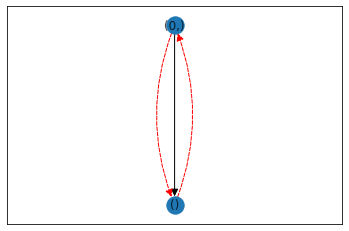

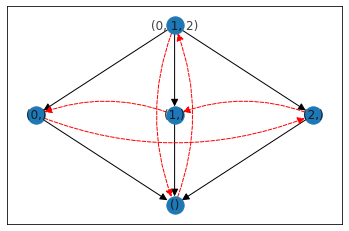

In [889]:
# Examples

l = lattice_with_neg(reflexive_closure([],[0]))

display_lattice_with_neg(l)

l = lattice_with_neg(reflexive_closure([(0,1),(1,2),(2,0)],range(3)))

display_lattice_with_neg(l)


In [890]:
def lattices_with_neg(rels):
    """given a collection rels of relations, returns all the fixpoint lattices with neg operation up to isomorphism"""

    lattices = []

    for rel in tqdm(rels):
        l = lattice_with_neg(rel)
        newlat = True
        for l2 in lattices:
            if nx.is_isomorphic(l,l2):
                newlat = False
                break
        if newlat:
            lattices.append(l)
       
    return lattices

In [891]:
def lattices_with_neg_keep_rels(rels):
    """given a collection rels of relations, returns all the fixpoint lattices with neg operation up to isomorphism,
    plus the relation from which each came"""

    rel_lat = []

    for rel in tqdm(rels):
        l = lattice_with_neg(rel)
        newlat = True
        for pair in rel_lat:
            l2 = pair[1]
            if nx.is_isomorphic(l,l2):
                newlat = False
                break
        if newlat:
            rel_lat.append((rel,l))
       
    return rel_lat

  0%|          | 0/218 [00:00<?, ?it/s]

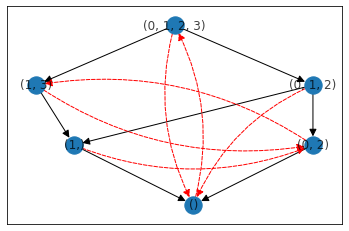

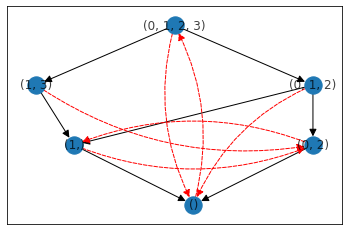

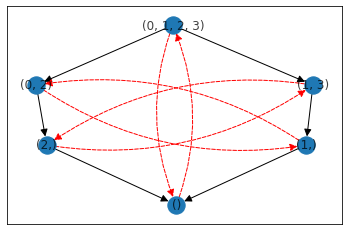

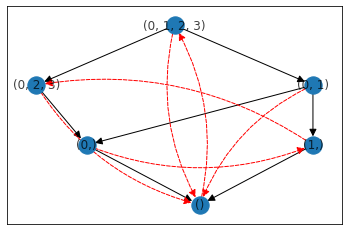

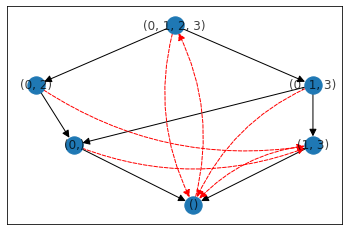

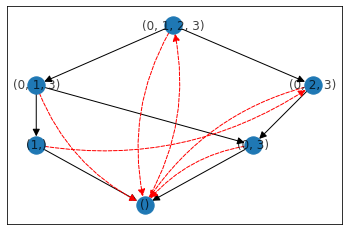

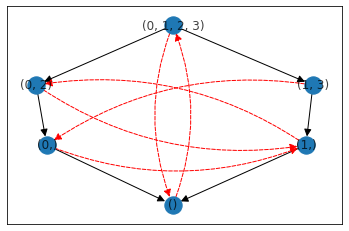

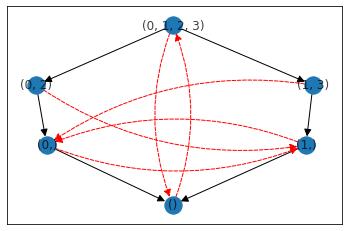

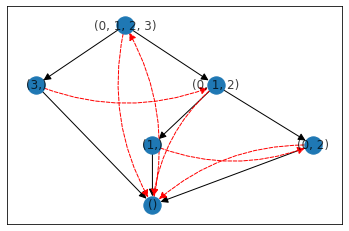

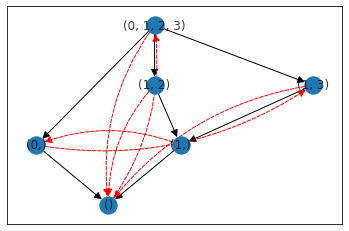

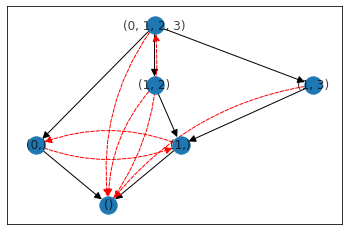

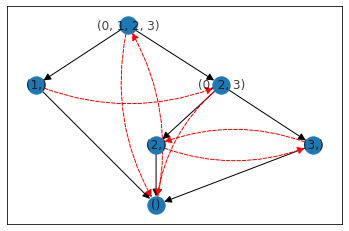

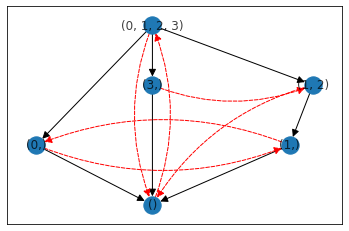

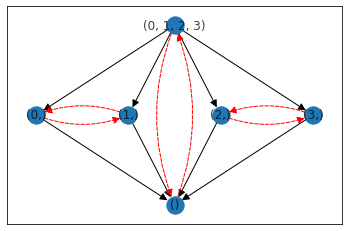

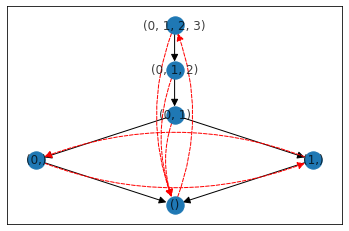

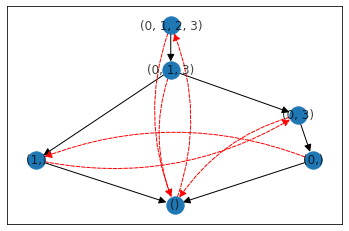

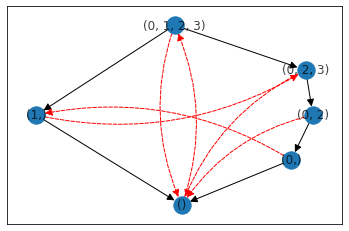

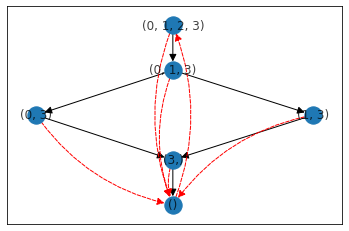

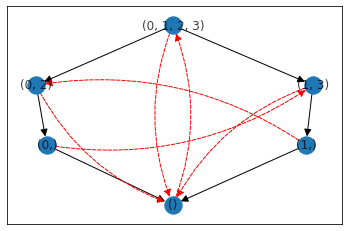

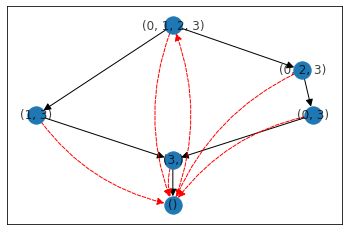

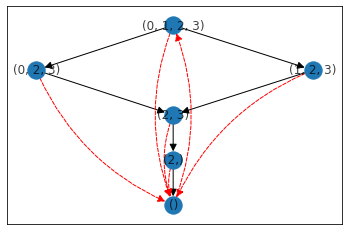

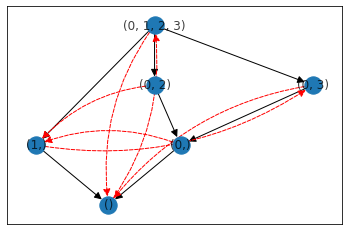

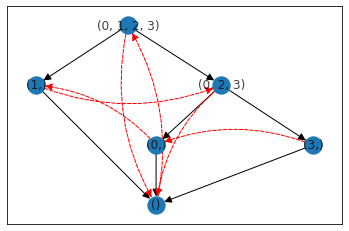

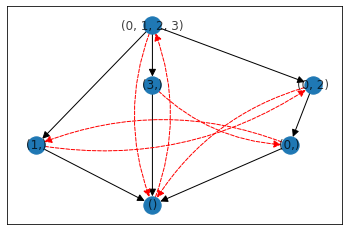

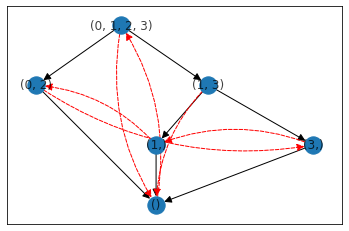

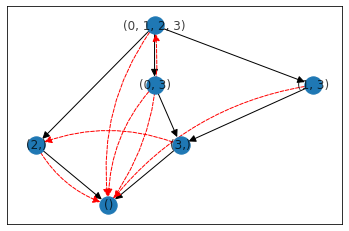

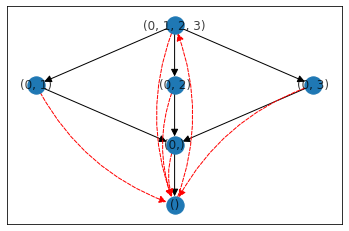

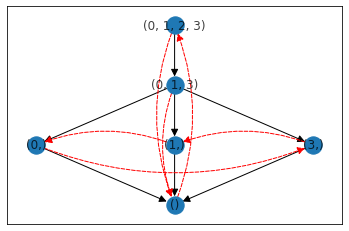

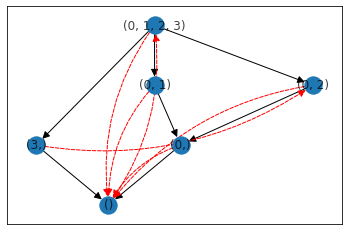

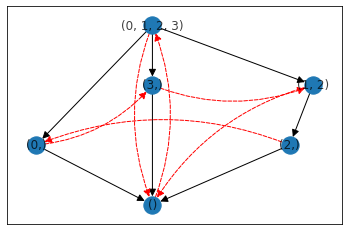

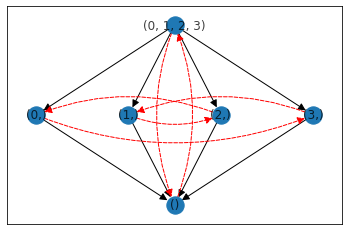

In [892]:
# Examples

for pair in lattices_with_neg_keep_rels(comp_frames_size(4)):
    if len(pair[1].nodes)==6:
        display_lattice_with_neg(pair[1])

### Lattices with $\neg$ from compatibility frames of size 1-4

In [893]:
lattices_with_neg_from_comp_frames_size = {n: lattices_with_neg(comp_frames_size(n)) for n in range(1,5)}

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

In [894]:
for n in range(1,5):
    print(f"Number of compatibility frames of size {n} up to iso: {len(comp_frames_size(n))}")
    print(f"Number of lattices up to iso from compatibility frames of size {n}: {len(lattices_from_comp_frames_size[n])}")
    print(f"Number of lattices with neg up to iso from compatibility frames of size {n}: {len(lattices_with_neg_from_comp_frames_size[n])}")
    print("\n")

Number of compatibility frames of size 1 up to iso: 1
Number of lattices up to iso from compatibility frames of size 1: 1
Number of lattices with neg up to iso from compatibility frames of size 1: 1


Number of compatibility frames of size 2 up to iso: 3
Number of lattices up to iso from compatibility frames of size 2: 3
Number of lattices with neg up to iso from compatibility frames of size 2: 3


Number of compatibility frames of size 3 up to iso: 16
Number of lattices up to iso from compatibility frames of size 3: 10
Number of lattices with neg up to iso from compatibility frames of size 3: 11


Number of compatibility frames of size 4 up to iso: 218
Number of lattices up to iso from compatibility frames of size 4: 59
Number of lattices with neg up to iso from compatibility frames of size 4: 103




In [895]:
for n in range(3,5):
    d_n = num_each_size(lattices_from_comp_frames_size[n])
    d_neg_n = num_each_size(lattices_with_neg_from_comp_frames_size[n])
    print(f"Number of lattices of each size arising from digraphs of size {n}:")
    pprint(d_n)
    print(f"Number of lattices with neg of each size arising from digraphs of size {n}:")
    pprint(d_neg_n)
    print("\n")

Number of lattices of each size arising from digraphs of size 3:
{2: 1, 3: 1, 4: 2, 5: 4, 6: 1, 8: 1}
Number of lattices with neg of each size arising from digraphs of size 3:
{2: 1, 3: 1, 4: 3, 5: 4, 6: 1, 8: 1}


Number of lattices of each size arising from digraphs of size 4:
{2: 1, 3: 1, 4: 2, 5: 5, 6: 14, 7: 14, 8: 6, 9: 9, 10: 5, 12: 1, 16: 1}
Number of lattices with neg of each size arising from digraphs of size 4:
{2: 1, 3: 1, 4: 4, 5: 17, 6: 31, 7: 23, 8: 10, 9: 9, 10: 5, 12: 1, 16: 1}




### Lattices with $\neg$ from compatibility frames of size 5

We separate the generation of lattices with $\neg$ from compatibility frames of size 5, since this takes a bit longer.

In [896]:
lattices_with_neg_from_comp_frames_size[5] = lattices_with_neg(comp_frames_size(5))

  0%|          | 0/9608 [00:00<?, ?it/s]

In [ ]:
n=5

print(f"Number of compatibility frames of size {n} up to iso: {len(comp_frames_size(n))}")
print(f"Number of lattices up to iso from compatibility frames of size {n}: {len(lattices_from_comp_frames_size[n])}")
print(f"Number of lattices with neg up to iso from compatibility frames of size {n}: {len(lattices_with_neg_from_comp_frames_size[n])}")

In [ ]:
n=5

d_n = num_each_size(lattices_from_comp_frames_size[n])
d_neg_n = num_each_size(lattices_with_neg_from_comp_frames_size[n])
print(f"Number of lattices of each size arising from compatibility frames of size {n}:")
pprint(d_n)
print(f"Number of lattices with neg of each size arising from compatibility frames of size {n}:")
pprint(d_neg_n)

# II Supplement to Section 3.1  <a id='II'></a>

In this section, we compute for a given lattice $L$, anti-inflationary operation $\neg$ on $L$, and set $\mathrm{V}$ of nonzero elements of $L$, the compatibility frame $(\mathrm{V},\vartriangleleft^\neg_\mathrm{V})$ from Def. 3.5(i) in the paper.

The lattice $L$ is always given as the lattice of fixpoints of some compatibility frame.

## II.I The compatibility relation of Def. 3.5(i)  <a id='II.I'></a>

In [ ]:
def escapes(A,B,neg,V):
    """checks if A escapes B in V with neg, where neg is represented as a function or dictionary"""
    
    Aset = set(A)
    Bset = set(B)
    if not Aset == set() and not Bset == set():
        for C in V:
            if callable(neg):
                negCset = set(neg(C))
            
            else:
                negCset = set(neg[C])
                
            if not Aset.issubset(negCset) and Bset.issubset(negCset):
                return True
            
    return False

In [ ]:
def compat(rel,neg,V,X=None):
    """where L is the fixpoint lattice of rel, returns the compatibility relation
    defined from L, neg, and V as in Def. 3.5(i)"""
    
    if X is None:
        X = domain(rel)
    
    fixpts = fixpoints(rel,X)
    
    comp = []
    for A in V:
        Aset = set(A)
        
        if callable(neg):
            negAset = set(neg(A))
        else:
            negAset = set(neg[A])
            
        for B in V:
            Bset = set(B)
            if not Bset.issubset(negAset):
                passes = True
                for C in fixpts:
                    Cset = set(C)
                    if Bset.issubset(Cset) and not Aset.issubset(Cset):
                          if not escapes(A,C,neg,V):
                                passes = False
                                break
                if passes:
                    comp.append((A,B))
    return comp

## II.II Finding join-irreducibles in the fixpoint lattice  <a id='II.II'></a>

In [ ]:
def is_join_irr(A,rel,X = None):
    """checks if A is join-irreducible in the fixpoint lattice of rel"""
    
    if X is None:
        X = domain(rel)
        
    fixpts = fixpoints(rel,X)
    Aset = set(A)
    
    if Aset == set():
        return False
    
    for B in fixpts:
        Bset = set(B)
        for C in fixpts:
            Cset = set(C)
            if not Bset == Aset and not Cset == Aset:
                union = Bset.union(Cset)
                closure_union = set(closure(union,rel,X))
                if Aset == closure_union:
                    return False
        
    return True

In [ ]:
def join_irrs(rel,X = None):
    """Returns the list of all join-irreducibles in the fixpoint lattice of rel"""
    
    if X is None:
        X = domain(rel)
    
    ji = []
    fixpts = fixpoints(rel,X)
    
    for A in fixpts:
        if is_join_irr(A,rel,X):
            ji.append(A)
            
    return ji

In [ ]:
rel = reflexive_closure([(1,0),(2,1)],range(3))

print(fixpoints(rel))

print(join_irrs(rel))

### Example

In [ ]:
rel = reflexive_closure([(0,1),(1,2),(2,0)],range(3))
print(f"Original compatibility frame: {rel}")

fixpts = fixpoints(rel)
print(f"Original fixpoints: {fixpts}")

print("\n")

l1 = lattice(rel) # This is the lattice we will try to obtain via the representation of Section 3.1

# To represent l1 as in Section 3.1, we need to pick neg and V

neg = neg_dict(rel) # neg is the protocomplementation defined from rel on the fixpoints lattice of rel
V = join_irrs(rel) # V is the set of join-irreducible elements of the fixpoints lattice of rel

compat_rel = compat(rel, neg, V) # This is the relation on V defined from l1 and neg as in Definition 3.5(i)
print(f"New compatibility frame: {compat_rel}")
compat_fixpts = fixpoints(compat_rel)
print(f"New fixpoints: {compat_fixpts}")

l2 = lattice(compat_rel)
               
nx.is_isomorphic(l1,l2)

## II.III Generating anti-inflationary functions <a id='II.III'></a>

In [ ]:
def f_generator(A, B):
    """generates all functions from A to B"""
    for b_values in product(B, repeat=len(A)):
        yield partial(lambda d, x: d[x], dict(zip(A, b_values)))

In [ ]:
def anti_inflationary_f_generator(A, B):
    """generates all functions from A to B that are 
    anti-inflationary with respect to set inclusion"""
    
    out = []
    for a in A:
        seta = set(a)
        out.append([b for b in B if seta == set() or not seta.issubset(set(b))])      
        
    for b_values in product(*out):
        yield partial(lambda d, x: d[x], dict(zip(A, b_values)))

In [ ]:
A = list(powerset(range(3)))
B = list(powerset(range(3)))
count = 0
for f in tqdm(f_generator(A,B)):
    count += 1
    
print(count)

In [ ]:
A = list(powerset(range(3)))
B = list(powerset(range(3)))
count = 0
for f in tqdm(anti_inflationary_f_generator(A,B)):
    count += 1
    
print(count)

In [ ]:
def anti_inflationary_negs(lt,X):
    """generates all the anti-inflationary functions on the fixpoint lattice lt
    up to isomorphism of the resulting lattice expansion"""
    
    ltset = set(lt)
    
    cover = covering(propsubrel(lt))
    
    lat_exps_of_lt = []
    fs = []
    Xtuple = tuple(X)
    
    for f in anti_inflationary_f_generator(ltset,ltset):
            newlat = True
            
            l = nx.MultiDiGraph()
            l.add_nodes_from(lt)
            l.add_edges_from(cover, weight=0)
            
            for A in ltset:
                l.add_edge(A,f(A), weight=1)
            
            for l2 in lat_exps_of_lt:
                if nx.is_isomorphic(l,l2):
                    newlat = False

            if newlat:
                lat_exps_of_lt.append(l)
                f_dict = {A: f(A) for A in ltset}
                fs.append(f_dict)
                    
    return fs

In [ ]:
def anti_inflationary_negs_V(lt,V,X):
    """like the previous function be we only look at anti-inflationary functions from V to lt"""
    
    Vset = set(V)
    ltset = set(lt)
    
    cover = covering(propsubrel(lt))
    
    lat_exps_of_lt = []
    fs = []
    Xtuple = tuple(X)
    
    for f in anti_inflationary_f_generator(Vset,ltset):
            newlat = True
            
            l = nx.MultiDiGraph()
            l.add_nodes_from(lt)
            l.add_edges_from(cover, weight=0)
            
            for A in Vset:
                l.add_edge(A,f(A), weight=1)
            
            for l2 in lat_exps_of_lt:
                if nx.is_isomorphic(l,l2):
                    newlat = False

            if newlat:
                lat_exps_of_lt.append(l)
                f_dict = {A: f(A) for A in Vset}
                fs.append(f_dict)
                    
    return fs

## II.IV Checking whether lattice(s) can be represented as in Def. 3.5(i) <a id='II.IV'></a>

In [ ]:
def represent_lat(rel,verbose = True):
    """checks whether the fixpoint lattice of rel is representable as in Section 3.1"""

    fixpts = fixpoints(rel)
    l1 = lattice(rel)

    if verbose == True:
        print(f"Original compatibility relation: {rel}")
        print(f"Lattice of fixpoints: {fixpts}")
        display_lattice(l1)
    
    k = len(domain(rel))
    can_rep = False
    ji = join_irrs(rel)
    
    for f in anti_inflationary_f_generator(ji,fixpts):
        comp = compat(rel,f,ji,domain(rel))
        l2 = lattice(comp)
        if nx.is_isomorphic(l1,l2):
            can_rep = True
            if verbose == True:
                print("Can find a neg and V to represent lattice via Def. 3.5(i).")
                print(f"V is the set of join-irreducibles: {ji}")
                print(f"The neg operation is: {f}")
                print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
                print("\n")
            break
            
    if can_rep == False:
        for V in powerset(fixpts):
            if () not in V:
                for f in anti_inflationary_f_generator(V,fixpts):
                    comp = compat(rel,f,V,domain(rel))
                    l2 = lattice(comp)
                    if nx.is_isomorphic(l1,l2):
                        can_rep = True
                        if verbose == True:
                            print("Can find a neg and V to represent lattice via Def. 3.5(i).")
                            print(f"The subset V is: {V}")
                            print(f"The neg operation is: {f}")
                            print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
                            print("\n")
                        break
            if can_rep == True:
                break
        
    if can_rep == False:
        print("Can't find a neg and V to represent lattice via Def. 3.5(i).")
        print("\n")

Next we verify that for every lattice $L$ of size $\leq 7$, there is a $\neg$ and $\mathrm{V}$ such that $L$ is isomorphic to $\mathfrak{L}(\mathrm{V},\vartriangleleft^\neg_\mathrm{V})$. We will verify this for every lattices of size $\leq 8$ in Section II.V below.

In [ ]:
for n in range(2,8):
    count = 0
    for rel in comp_frames_for_lats_size[n]:
        count +=1
        print(f"{n},{count}")
        represent_lat(rel)

Among lattice up to size 6, for all but one, we can take $\mathrm{V}$ in the representation to be the set of join-irreducible elements. The one exception is the following.

In [ ]:
rel = [(0, 2), (2, 0), (0, 3), (0, 4), (4, 0), (1, 3), (3, 1), (4, 1), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]

represent_lat(rel)

## II.V Checking whether a lattice can be represented as in Def. 3.5(i) for a given $\neg$ and/or $\mathrm{V}$ <a id='II.V'></a>

In [ ]:
def represent_lat_with_neg_V(rel, neg, V, verbose = True):
    """checks whether the fixpoint lattice of rel is successfully represented
    by the compatibility relation defined from f and V as in Definition 3.5(i)"""
    
    fixpts = fixpoints(rel)
    l1 = lattice(rel)
    
    if verbose == True:
        print(f"Original compatibility relation: {rel}")
        print(f"Lattice of fixpoints: {fixpts}")
        display_lattice(l1)
    
    comp = compat(rel,neg,V,domain(rel))
    l2 = lattice(comp)

    if nx.is_isomorphic(l1,l2):
        if verbose == True:
            print("Can represent lattice via Def. 3.5(i) with the given neg and V.")
            print(f"The subset V is: {V}")
            print(f"The neg operation is: {neg}")
            print(f"The compatibility relation from Definition 3.5(i) is: {comp}") 
               
    else:
        print("Can't represent lattice via Def. 3.5(i) with the given neg and V.")
        print("\n")

In [ ]:
# An example

rel = [(0, 2), (2, 0), (0, 3), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]

neg = neg_dict(rel)

V = join_irrs(rel)

represent_lat_with_neg_V(rel,neg,V)

In [ ]:
def represent_lat_with_neg(rel,neg, verbose = True):
    """checks whether there is a V such that fixpoint lattice of rel is successfully represented
    by the compatibility relation defined from neg and V as in Definition 3.5(i)"""
    
    fixpts = fixpoints(rel)
    l1 = lattice(rel)

    if verbose == True:
        print(f"Original compatibility relation: {rel}")
        print(f"Lattice of fixpoints: {fixpts}")
        display_lattice(l1)
    
    k = len(domain(rel))
    can_rep = False
    ji = join_irrs(rel)
    
    comp = compat(rel,neg,ji,domain(rel))
    l2 = lattice(comp)
    if nx.is_isomorphic(l1,l2):
        can_rep = True
        if verbose == True:
            print("Can find a V to represent lattice via Def. 3.5(i) with the given neg.")
            print(f"V is the set of join-irreducibles: {ji}")
            print(f"The anti-inflationary operation is: {neg}")
            print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
            print("\n")

    if can_rep == False:
        for V in powerset(fixpts):
            if () not in V:
                comp = compat(rel,neg,V,domain(rel))
                l2 = lattice(comp)
                if nx.is_isomorphic(l1,l2):
                    can_rep = True
                    if verbose == True:
                        print("Can find a V to represent lattice via Def. 3.5(i) with the given neg.")
                        print(f"The subset V is: {V}")
                        print(f"The neg operation is: {neg}")
                        print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
                        print("\n")
                    break
        
    if can_rep == False:
        print("Can't find a V to represent lattice via Def. 3.5(i) with the given neg.")
        print("\n")

In [ ]:
# Continuing the previous example

rel = [(0, 2), (2, 0), (0, 3), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]

neg = neg_dict(rel)

represent_lat_with_neg(rel,neg)

In [ ]:
def represent_lat_with_V(rel, V, verbose = True):
    """checks whether there is a neg such that fixpoint lattice of rel is successfully represented
    by the compatibility relation defined from neg and V as in Definition 3.5(i)"""

    fixpts = fixpoints(rel)
    l1 = lattice(rel)

    if verbose == True:
        print(f"Original compatibility relation: {rel}")
        print(f"Lattice of fixpoints: {fixpts}")
        display_lattice(l1)
    
    k = len(domain(rel))
    can_rep = False

    for neg in anti_inflationary_f_generator(V,fixpts):
        comp = compat(rel,neg,V,domain(rel))
        l2 = lattice(comp)
        if nx.is_isomorphic(l1,l2):
            can_rep = True
            if verbose == True:
                print("Can find a neg to represent lattice via Def. 3.5(i) with the given V.")
                print(f"The subset V is: {V}")
                print(f"The neg operation is: {neg}")
                print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
                print("\n")
            break
        
    if can_rep == False:
        print("Can't find a neg to represent lattice via Def. 3.5(i) with the given V.")
        print("\n")

In [ ]:
# Continuing the previous example

rel = [(0, 2), (2, 0), (0, 3), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]

V = join_irrs(rel)

represent_lat_with_V(rel,V)

## II.VI All lattices of size $\leq 8$ can be represented as in Def. 3.5(i)<a id='II.VI'></a>

We already saw in Section II.IV that all lattices of size $\leq 7$ can be represented by compatibility frames via Def. 3.5(i). In this section, we establish this for lattices of size $\leq 8$.

Running the code from Section II.IV for comp_frames_for_lats_size[8] takes a long time. I did so and saved all the relevant data in a pickle file: the file generate/rels_for_lats_size_8_with_neg_and_V.pkl stores a dictionary whose values are triples $(\mathcal{F}, \neg, \mathrm{V})$ where $\mathcal{F}$ is a compatibility frame that gives rise to a lattice $L$ of size $8$, and $\neg$ and $\mathrm{V}$ are such that $L$ is isomorphic to $\mathfrak{L}(\mathrm{V},\vartriangleleft^\neg_\mathrm{V})$. There are 222 such triples, one for each of the lattices of size $8$.

In [ ]:
rels_for_lats_size_8_with_neg_and_V = pickle.load(open("generated/rels_for_lats_size_8_with_neg_and_V.pkl", 'rb'))

In [ ]:
len(lattices([rels_for_lats_size_8_with_neg_and_V[n][0] for n in range(222)]))
# Double checking that we are considering 22 non-isomorphic lattices

In [ ]:
for n in range(0,222):
    triple = rels_for_lats_size_8_with_neg_and_V[n]
    represent_lat_with_neg_V(triple[0], triple[1], triple[2], verbose = False) # delete 'verbose = False' to see analysis of each lattice

## II.VII Verification of Conjecture 3.13 for lattices of size $\leq 16$<a id='II.VII'></a>

In this section, we check the sufficient condition in Footnote 5 for a finite lattice to be representable by a smaller compatibility frame as in Conjecture 3.13. 

As our source of lattices, we use the catalogue generated by Gebhardt and Tawn:

Gebhardt, V. and S. Tawn (2020), "Constructing unlabelled lattices," *Journal of Algebra*, Vol. 545, pp. 213–236.

Their lattices of size $n\leq 12$ can be found in lattices/latticesn.txt. 

I also ran the code below on lattices of size $13$, $14$, $15$, and $16$, but the files for these lattices are too big for GitHub. They can be found at https://research-data.westernsydney.edu.au/published/ff5d9c10519311ecb15399911543e199/

To find the minimum edge covering for a bipartite graph, we use the min_edge_cover function in networkx, which is based on:

J. E. Hopcroft and R. M. Karp (1973), "An $n^{5/2}$ algorithm for maximum matchings in bipartite graphs," *SIAM J. Comput*, Vol. 2, No. 4, pp. 225-231.

## Lattices

In [ ]:
def readlats(filename,n):
    """Read in lattices of size n represented by their covering relations 
    in the format of Gebhardt and Tawn"""
    
    file = open(filename)
    lines = file.readlines()
    lats = []

    for line in tqdm(lines):
        cover_rel = []
        l = list(line)

        for A in range(1,n+1):
            for B in range(1,n+1):
                if A<B:
                    if l[int((((B-1)*(B-2))/2)+A)-1] == '1':
                        cover_rel.append((A,B))
        
        lats.append(cover_rel)

    return lats

In [ ]:
lats_size = {}

for n in range(2,13):
    lats_size[n] = readlats(f"lattices/lattices{n}.txt",n)

In [ ]:
def graph_from_cover(cover, n):
    """Given a covering relation of a lattice of size n, 
    return a digraph where an arrow from y to x means that x covers y"""
    
    g = nx.DiGraph()
    g.add_nodes_from(range(1,n+1))
    
    for x in range(1,n+1):
        for y in range(1,n+1):
            if (x,y) in cover:
                g.add_edge(y,x)
    return g

In [ ]:
for lat in lats_size[5]:

    g = graph_from_cover(lat,5)

    nx.draw(g)
    plt.show()

In [ ]:
def join_irreducibles(cover,n):
    """Given a covering relation of a lattice of size n, return the join-irreducibles"""
    
    ji = []
    for x in range(1,n+1):
        if len([y for y in range(1,n+1) if (x,y) in cover ])==1:
            ji.append(x)
            
    return ji

In [ ]:
def meet_irreducibles(cover,n):
    """Given a covering relation of a lattice of size n, return the meet-irreducibles"""
    
    mi = []
    for x in range(1,n+1):
        if len([y for y in range(1,n+1) if (y,x) in cover ])==1:
            mi.append(x)
            
    return mi

In [ ]:
join_irreducibles(lats_size[11][42],11)

In [ ]:
meet_irreducibles(lats_size[11][42],11)

### The bipartite graph of irreducibles

In [ ]:
from networkx import bipartite

In [ ]:
def bipartite_of_irreducibles(cover,n):
    """Given the covering relation of a lattice of size n, return the bipartite graph of join- and meet-irreducibles
    as in Footnote 5"""
    
    mi = meet_irreducibles(cover,n)
    ji = join_irreducibles(cover,n)
    g = graph_from_cover(cover,n)
    
    gt = nx.transitive_closure(g,reflexive=True) 
    # We use gt to check that a given join-irreducible is not under a meet-irreducible in the lattice
    
    b = nx.Graph()
    b.add_nodes_from([(x,0) for x in mi],bipartite=0)
    b.add_nodes_from([(x,1) for x in ji],bipartite=1)
    
    for x in ji:
        for y in mi:
            if not (x,y) in gt.edges:
                b.add_edge((x,1),(y,0))
                
    return b

In [ ]:
def display_bipartite(b):
    """Display the bipartite graph b using networkx's bipartite layout"""
    
    top_nodes = {n for n, d in b.nodes(data=True) if d["bipartite"] == 0}
    pos = nx.bipartite_layout(b,top_nodes)
    nx.draw(b, pos)
    plt.show()

In [ ]:
b = bipartite_of_irreducibles(lats_size[11][42],11)

display_bipartite(b)

### Minimum edge covering

In [ ]:
bipartite_of_irreducibles(lats_size[5][0],5).edges

In [ ]:
nx.min_edge_cover(bipartite_of_irreducibles(lats_size[5][0],5))

The networkx min_edge_cover function sometimes outputs a redundant representation of a mininum edge covering containing both $(x,y)$ and $(y,x)$ to represent an undirected edge between $x$ and $y$, so we need the following.

In [ ]:
def non_redundant(rel):
    """Turns rel into a non-redundant representation of an undirected graph"""
    newrel = []
    
    for pair in rel:
        if not pair in newrel and not (pair[1],pair[0]) in newrel:
            newrel.append(pair)
            
    return newrel
    

### Finding an edge covering smaller than the lattice

In [ ]:
def smaller_min_edge_cover(lat,n):
    """Checks for a given lattice of size n whether the minimum edge cover for 
    its bipartite graph of join-irreducibles and meet-irreducibles
    is smaller than the lattice itself"""
    
    b = bipartite_of_irreducibles(lat,n)
    
    smaller = True
    
    if len(b.edges) >= n:
        if len(non_redundant(nx.min_edge_cover(b))) >= n:
            smaller = False
            
    return smaller

In [ ]:
for n in range(2,13):
    
    # n=12 takes about 10 minutes
    # n=13 takes about an hour
    # n=14 takes about 8 hours

    verified = True

    for lat in tqdm(lats_size[n]):
        if not smaller_min_edge_cover(lat,n): 
                print("Minimum edge cover not smaller than lattice.")
                print(lat)
                verified = False
                break

    if verified == True:
        print(f"Conjecture 3.13 verified for lattices of size {n}.")

I also ran the code above for $n=13$ and $n=14$, which verified Conjecture 3.13 for lattices up to size $14$. 

For $n=15$ ($n=16$), the text file lattices15.txt is 16GB (resp. lattices16.txt is 178GB), so instead of loading the lines into a list we read the file line by line as follows.

In [ ]:
#n = 15 #takes a couple days
n = 2

for line in open(f"lattices/lattices{n}.txt"):
 
        cover_rel = []
        l = list(line)

        for A in range(1,n+1):
            for B in range(1,n+1):
                if A<B:
                    if l[int((((B-1)*(B-2))/2)+A)-1] == '1':
                        cover_rel.append((A,B))

        if not smaller_min_edge_cover(cover_rel,n): 
            print("Minimum edge cover not smaller than lattice.")
            print(lat)
            verified = False
            break 

Running the above code for $n=15$ took about 2 days and verified Conjecture 3.13 for lattices up to size 15.

Running the above code for $n=16$ took several weeks and verified Conjecture 3.13 for lattices up to size 16.

# III. Supplement to Appendix A.1 <a id='III'></a>

## III.I Generating protocomplementations <a id='III.I'></a>

In this section, we take a lattice arising from a compatibility frame and expand it with all possible protocomplementations as in Definition 2.14 in the paper, not just the protocomplementation arising from the compatibility frame.

In [ ]:
def antitone(f,dom):
    """checks whether a function on dom is an antitone wrt set inclusion"""
    
    for A in dom:
        Aset = set(A)
        fAset = set(f(A))
        
        for B in dom:
            Bset = set(B)
            fBset = set(f(B))         
            if Aset.issubset(Bset) and not fBset.issubset(fAset):
                return False
            
    return True

In [ ]:
def expand_with_protocomps(lt, X):
    """given a list of tuples representing a bounded meet-semilattice L of subsets of X
    return all nonisomorphic expansions of L with a protocomplementation"""
    
    ltset = set(lt)
    
    cover = covering(propsubrel(lt))
    
    lat_exps_of_lt = []
    Xtuple = tuple(X)
    
    for f in anti_inflationary_f_generator(ltset,ltset):
        if f(()) == Xtuple: # make sure $f(0) = 1$ as required for a protocomplementation
            if antitone(f,ltset):
                newlat = True
            
                l = nx.MultiDiGraph()
                l.add_nodes_from(lt)
                l.add_edges_from(cover, weight=0)
            
                for A in ltset:
                    l.add_edge(A,f(A), weight=1)
            
                for l2 in lat_exps_of_lt:
                    if nx.is_isomorphic(l,l2):
                        newlat = False
                        break
                if newlat:
                    lat_exps_of_lt.append(l)
            
    return lat_exps_of_lt

In [ ]:
def expand_all_with_protocomps(lts,X):
    
    lat_exps_of_lts = []
    for lt in lts:
        lat_exps = expand_with_protocomps(lt, X)
        lat_exps_of_lts = lat_exps_of_lts + lat_exps
    
    return lat_exps_of_lts

In [ ]:
def protocomps(lt, X):
    """given a list of tuples representing a bounded meet-semilattice L of subsets of X
    returns all protocomplementations up to isomorphism of the expansion of L"""
    
    ltset = set(lt)
    
    cover = covering(propsubrel(lt))
    
    lat_exps_of_lt = []
    fs = []
    Xtuple = tuple(X)
    
    for f in anti_inflationary_f_generator(ltset,ltset):
        if f(()) == Xtuple: # make sure $f(0) = 1$ as required for a protocomplementation
            if antitone(f,ltset):
                newlat = True
            
                l = nx.MultiDiGraph()
                l.add_nodes_from(lt)
                l.add_edges_from(cover, weight=0)
            
                for A in ltset:
                    l.add_edge(A,f(A), weight=1)
            
                for l2 in lat_exps_of_lt:
                    if nx.is_isomorphic(l,l2):
                        newlat = False

                if newlat:
                    lat_exps_of_lt.append(l)
                    f_dict = {A: f(A) for A in ltset}
                    fs.append(f_dict)
                    
    return fs

In [ ]:
# An example

rel = reflexive_closure([(1,0),(2,1)],range(3))

for d in protocomps(fixpoints(rel),range(3)):
    print(d)

In [ ]:
rel = [(0, 2), (2, 0), (0, 3), (4, 0), (2, 1), (1, 3), (3, 1), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
# The fixpoint lattice of this rel admits only one protocomplementation

print(protocomps(fixpoints(rel),range(5)))

## III.II Lattices for which no protocomplementation makes the representation of Def. 3.5(i) apply <a id='III.IV'></a>

So far, for every finite lattice $L$ we have tested, we have found an anti-inflationry operation $\neg$ and set $\mathrm{V}$ of nonzero elements such that $L$ is isomorphic to $\mathfrak{L}(\mathrm{V},\vartriangleleft^\neg_\mathrm{V})$. However, we will now see that we cannot always do this with a protocomplementation $\neg$.


In [ ]:
def represent_lat_using_proto(rel, verbose = True):
    """checks whether the fixpoint lattice of rel is representable as in Section 3.1
    when neg is a protocomplementation"""

    fixpts = fixpoints(rel)
    l1 = lattice(rel)

    if verbose == True:
        print(f"Original compatibility relation: {rel}")
        print(f"Lattice of fixpoints: {fixpts}")
        display_lattice(l1)
    
    k = len(domain(rel))
    can_rep = False
    ji = join_irrs(rel)
    
    for f in protocomps(fixpts,range(k)):
        comp = compat(rel,f,ji)
        l2 = lattice(comp)
        if nx.is_isomorphic(l1,l2):
            can_rep = True
            if verbose == True:
                print("Can find a protocomplementation and V to represent lattice via Def. 3.5(i).")
                print(f"V is the set of join-irreducibles: {ji}")
                print(f"The protocomplementation is: {f}")
                print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
                print("\n")
            break
    
    if can_rep == False:
        for V in powerset(fixpts):
            if () not in V:
                for f in protocomps(fixpts,range(k)):
                    comp = compat(rel,f,V,domain(rel))
                    l2 = lattice(comp)
                    if nx.is_isomorphic(l1,l2):
                        can_rep = True
                        if verbose == True:
                            print("Can find a protocomplementation and V to represent lattice via Def. 3.5.1.")
                            print(f"The subset V is: {V}")
                            print(f"The protocomplementation is: {f}")
                            print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
                            print("\n")
                        break
            if can_rep == True:
                break
        
    if can_rep == False:
        print("Can't find a protocomplementation and V to represent lattice via Def. 3.5(i).")
        print("\n")

In [ ]:
for n in range(5,7):
    for rel in comp_frames_for_lats_size[n]:
        represent_lat_using_proto(rel)

### Example

In [ ]:
rel = [(0, 2), (2, 0), (0, 3), (4, 0), (2, 1), (1, 3), (3, 1), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
# The fixpoint lattice L of this rel admits only one protocomplementation, 
# which sends every nonzero element to zero. 
print(protocomps(fixpoints(rel),range(5)))
print("\n")

represent_lat_using_proto(rel)
# We cannot represent L as in Def. 3.5(i) by taking neg to be the one protocomplementation.

represent_lat(rel)
# But we can represent L as in Def. 3.5(i) by taking neg to be another anti-inflationary operation.

## III.III Checking whether $(L,\neg)$ can arise from a compatibiltiy frame <a id='III.II'></a>

So far, we have concentrated on the representation of lattices. Appenix A.1 concerns the representation of lattice expansions $(L,\neg)$. That is, given a lattice $L$ and protocomplementation $\neg$ on $L$, we seek a compatibility frame $(X,\vartriangleleft)$ such that $(L,\neg)$ is isomorphic to $(\mathfrak{L}(X,\vartriangleleft),\neg_\vartriangleleft)$.

In [ ]:
def search_for_iso(targets,realized):
    """checks whether each lattice expansion in targets is isomorphic to some lattice expansion in realized"""
    count = -1
    for l in targets:
        count += 1
        i = len(l.nodes)
        canrealize = False
        for l2 in realized:
            if nx.is_isomorphic(l,l2):
                    canrealize = True
                    print(f"Can realize this lattice expansion (#{count}) of size {i}.")
                    break
        if canrealize == False:
                print(f"Can't realize this lattice expansion (#{count}) of size {i}:")
                coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
                negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]
                print(f"Covering relation: {coveredges}")
                print(f"Neg operation: {negedges}")
                display_lattice_with_neg(l)

In [ ]:
def search_for_iso_keep_rels(targets,realized):
    """same as above but saves the relation that represents the target lattice expansion"""
    count = -1
    rel_realizers = {}
    for l in targets:
        count += 1
        i = len(l.nodes)
        canrealize = False
        for pair in realized:
            l2 = pair[1]
            if nx.is_isomorphic(l,l2):
                    canrealize = True
                    print(f"Can realize this lattice expansion (#{count}) of size {i}.")
                    rel_realizers[l] = pair[0]
                    break
        
        if canrealize == False:
                print(f"Can't realize this lattice expansion (#{count}) of size {i}:")
                coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
                negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]
                print(f"Covering relation: {coveredges}")
                print(f"Neg operation: {negedges}")
                display_lattice_with_neg(l)
                
    return rel_realizers

### Example with an expansion of $\mathbf{M}_3$

For example, below we generate every expansion up to isomorphism of the $\mathbf{M}_3$ lattice with a protocomplementation. Recall that $\mathbf{M}_3$ arises as the lattice of fixpoints of a cycle on 3 elements.

In [ ]:
M3_expansions = expand_with_protocomps(fixpoints(reflexive_closure([(0,1),(1,2),(2,0)],range(3))),range(3))

for l in M3_expansions:
    
    coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
    negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]
    print(f"Covering relation: {coveredges}")
    print(f"Neg operation: {negedges}")
    display_lattice_with_neg(l)

Next we check if every expansion of the 5-element $\mathbf{M}_3$ lattice with a protocomplementation $\neg$ can be represented by a 4-element compatibility frame.

In [ ]:
search_for_iso(M3_expansions,lattices_with_neg_from_comp_frames_size[4])

In [ ]:
# Displaying the last expansion of M3 that is not representable by any 4-element compatibility frame

M3exp = M3_expansions[6]

display_lattice_with_neg(M3exp)

Next we find a 5-element compatibility frame that realizes the desired expansion of $\mathbf{M}_3$. Instead of performing the search with the next two cells, which takes several minutes, one can uncomment rel_for_M3exp in the third cell below.

In [ ]:
lats_with_neg_keep_rels_from_comp_frames_size_5 = lattices_with_neg_keep_rels(comp_frames_size(5))
# Can skip this and uncomment rel_for_M3exp below

In [ ]:
rel_for_M3exp = search_for_iso_keep_rels([M3exp],lats_with_neg_keep_rels_from_comp_frames_size_5)[M3exp]
print("\n")
print(f"Representing relation: {rel_for_M3exp}")

In [ ]:
# Here is the 5-element compatibility frame that realizes the desired expansion of M3

print("Representing compatibility frame:")

# rel_for_M3exp = [(0, 2), (2, 0), (0, 3), (3, 0), (4, 0), (1, 2), (2, 1), (3, 1), (1, 4), (4, 1), (2, 3), (2, 4), (3, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]

draw_flipped_digraph(rel_for_M3exp)

print("Fixpoint lattice:")
l = lattice_with_neg(rel_for_M3exp)

coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]

pos = nx.spring_layout(l)
nx.draw_networkx_nodes(l,pos)
nx.draw_networkx_edges(l, pos, edgelist=coveredges)
nx.draw_networkx_edges(l, pos, edgelist=negedges,style="dashed",connectionstyle="arc3,rad=0.1")
plt.show() 

print("Check if isomorphic to the desired expansion of M3:")
print(nx.is_isomorphic(l,M3exp))


### Lattice expansions of size $\leq 5$

We now show that all lattices of size $\leq 5$ expanded with a protocomplementation can be represented by compatibility frames of size $\leq 5$.

In [ ]:
m = 5 # the size of the lattice expansions

comp_frames_for_lats_size_leq_m = [pair[0] for pair in lattices_keep_rels(comp_frames_size(m-1)) if len(fixpoints(pair[0]))<= m]
# instead of running over all of comp_frames(m-1)
# we just use the graphs that we know are sufficient to generate all lattices of size \leq m up to isomorphism

fxpts_lats = [fixpoints(d) for d in comp_frames_for_lats_size_leq_m]

lats_size_leq_m_plus_protocomps = expand_all_with_protocomps(fxpts_lats,range(m-1))

In [ ]:
print("Number of lattice expansions up to iso from adding a protocomplementation to a lattice of size <=m:")
print(len(lats_size_leq_m_plus_protocomps))

print("Number of lattice expansions up to iso of size <=m arising from compatibility frames of size <=m:")
lats_size_leq_m_with_neg_from_comp_frames_size_leq_m = [l for l in lattices_with_neg_from_comp_frames_size[m] if len(l.nodes) <= m]
print(len(lats_size_leq_m_with_neg_from_comp_frames_size_leq_m))

In [ ]:
search_for_iso_keep_rels(lats_size_leq_m_plus_protocomps,lats_with_neg_keep_rels_from_comp_frames_size_5)

### Lattice expansions of size 6

Finally, we show there is one lattice of size $6$ expanded with a protocomplementation that cannot be represented by a compatibility frame of size $\leq 6$, for which it suffices show that it cannot be represented by any compatibility frame of size 6.

In [ ]:
comp_frames_for_lats_size_6 = [pair[0] for pair in lattices_keep_rels(comp_frames_size(5)) if len(fixpoints(pair[0])) == 6]

fxpts_lats_6 = [fixpoints(d) for d in comp_frames_for_lats_size_6]

lats_size_6_plus_protocomps = expand_all_with_protocomps(fxpts_lats_6,range(5))

In [ ]:
print("Number of lattice expansions up to iso from adding a protocomplementation to a lattice of size 6:")
print(len(lats_size_6_plus_protocomps))

On my machine with digraph6.txt available, I applied the following function to comp_frames_size(6), 6. This computes all the lattices up to size 6 with negation up to isomorphism that arise from compatibility frames of size 6, saving the compatibility frame for each lattice. I then stored the list of compatibility frames in the file comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6.pkl, which is in the generated directory.

In [ ]:
def rels_for_lattices_with_neg_of_size(rels,n):
    """given a collection rels of relations, 
    only keeps those relations that give rise to 
    non-isomorphic fixpoints lattices of size n with neg operation""" 

    kept_rels = []
    lats = []

    for rel in tqdm(rels):
        l = lattice_with_neg(rel)
        if len(l.nodes) == n:
            newlat = True
            for l2 in lats:
                if nx.is_isomorphic(l,l2):
                    newlat = False
                    break
            if newlat:
                kept_rels.append(rel)
                lats.append(l)
    
    return kept_rels

In [ ]:
#comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6 = rels_for_lattices_with_neg_of_size(comp_frames_size(6),6)
#pickle.dump(rels_6, open("comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6", "wb")) 

In [ ]:
comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6 = pickle.load(open("generated/comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6.pkl", "rb"))

In [ ]:
print("Number of lattice expansions up to iso of size 6 arising from compatibility frames of size 6:")
lats_size_6_with_neg_from_comp_frames_size_6 = [lattice_with_neg(d) for d in comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6]
print(len(lats_size_6_with_neg_from_comp_frames_size_6))

Below we display the one 6-element lattice with protocomplementation that does not arise from any compatibility frame of size 6.

In [ ]:
for l in lats_size_6_plus_protocomps:
    can_realize = False
    for l2 in lats_size_6_with_neg_from_comp_frames_size_6:
        if nx.is_isomorphic(l,l2): 
            can_realize = True
            break
            
    if not can_realize:
        display_lattice_with_neg(l)